In [ ]:
# Start writing code here...

> Scott Lundberg paper in SHAP: https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

In [2]:
import sys
sys.path.append('..')

import os
import shap
import pickle
import tempfile
import shap
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd

from  sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from lib.supervised_tuning import  read_target_shifted_data
from lib.explainability import shap_deepnote_show, get_explainer_shap, get_kernel_explainer_shap, get_tree_explainer_shap, create_over_under_pred

%matplotlib inline


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [3]:
shap.initjs()

## Load numpy arrays and dataframes from pickle files

In [4]:
data_dir = "../assets/train_test_target_shifted/"
train_test_dict_file_name = "train_test_dict_target_shifted.pickle"
X_train_df_file_name = "X_train_impute_target_shifted_df.pkl"
X_test_df_file_name = "X_test_impute_target_shifted_df.pkl"

train_test_dict, X_train_impute_df, X_test_impute_df = read_target_shifted_data(
    data_dir, train_test_dict_file_name, X_train_df_file_name, X_test_df_file_name
)
X_train_impute = train_test_dict["X_train_impute"]
X_test_impute = train_test_dict["X_test_impute"]
X_pred_impute = train_test_dict["X_pred_impute"]

y_train_df = train_test_dict['y_train']
y_test_df = train_test_dict['y_test']
y_pred_df = train_test_dict['y_pred']


y_train = y_train_df['GSE_GWE_SHIFTED'].values.ravel()
y_test = y_test_df['GSE_GWE_SHIFTED'].values.ravel()
y_pred = y_pred_df['GSE_GWE_SHIFTED'].values.ravel()




#### Read Previously Stored models 

In [5]:
with open('../assets/models/supervised_learning_models/models.pickle', 'rb') as file:
        models = pickle.load(file)

Since the RandomForestRegressor has the best MAE in the train set evaluation and is very close to the best in the test set evaluation, the model is being picked to be evaluated with the help of SHAP.

In [6]:
for model in models:
    regressor_name = type(model.best_estimator_.regressor_).__name__ 
    y_pred_df[regressor_name] = model.best_estimator_.predict(X_pred_impute)
y_pred_df.drop(columns=[])

,,GSE_GWE_SHIFTED,XGBRegressor,SVR,KNeighborsRegressor,GradientBoostingRegressor,CatBoostRegressor,RandomForestRegressor
TOWNSHIP_RANGE,YEAR,,,,,,,
T01N R02E,2021,NaN,56.801914,56.470355,114.458490,55.132342,55.936966,92.342528
T01N R03E,2021,NaN,32.689034,40.547124,64.270152,46.068579,30.619183,27.540840
T01N R04E,2021,NaN,19.502710,28.627116,60.111441,20.923116,21.654736,19.182664
T01N R05E,2021,NaN,26.481182,32.469002,79.537479,27.518669,23.568367,22.395348
T01N R06E,2021,NaN,39.996876,49.348293,156.758876,39.327920,35.367359,74.177929
...,...,...,...,...,...,...,...,...
T32S R26E,2021,NaN,199.522797,193.625010,206.672807,202.639403,196.930644,203.823184
T32S R27E,2021,NaN,130.441605,102.033365,159.778706,127.136327,123.554569,126.552513
T32S R28E,2021,NaN,198.805740,194.919167,192.071090,200.737654,189.598111,201.733590


### Explain the test predictions for which we have target data


In [7]:
y_pred_test_df = y_test_df.copy()
for model in models:
    regressor_name = type(model.best_estimator_.regressor_).__name__ 
    if regressor_name in ['SVR', 'RandomForestRegressor']:
        y_pred_test_df[regressor_name] = model.best_estimator_.predict(X_test_impute)

y_pred_test_svr = y_pred_test_df[['GSE_GWE_SHIFTED', 'SVR']]
y_pred_test_rf = y_pred_test_df[['GSE_GWE_SHIFTED', 'RandomForestRegressor']]

for df in [y_pred_test_svr, y_pred_test_rf]:
    for col in df.columns:
        if col != 'GSE_GWE_SHIFTED' : 
            df[f"{col}_diff"] = df[col] - df['GSE_GWE_SHIFTED']
            df.sort_values(by=[f'{col}_diff'], inplace=True)

In [8]:
y_pred_test_rf.head(2)

,,GSE_GWE_SHIFTED,RandomForestRegressor,RandomForestRegressor_diff
TOWNSHIP_RANGE,YEAR,,,
T27S R26E,2020,443.66,182.377431,-261.282569
T27S R27E,2020,626.46,442.341674,-184.118326


In [9]:
y_pred_test_rf.tail(2)

,,GSE_GWE_SHIFTED,RandomForestRegressor,RandomForestRegressor_diff
TOWNSHIP_RANGE,YEAR,,,
T10S R21E,2020,27.300,259.095492,231.795492
T15S R10E,2020,182.335,430.852246,248.517246


The top and bottom rows of these dataframes indicate the greatest negative under-prediction and greatest positive over-predictions of the test data respectively. We can dig into what the SHAP explainability informs us about the features in these rows and how those features contribute to the predicted value to baseline difference.

In [ ]:
#https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c

### Explainability through SHAP  
- The background distribution is the entire train datset. For small problems this background dataset can be the whole training set, but for larger problems, a single reference value or using the kmeans function to summarize the dataset is recommended.
- For every model, pick an instance to explain feature importance

RandomForestRegressor


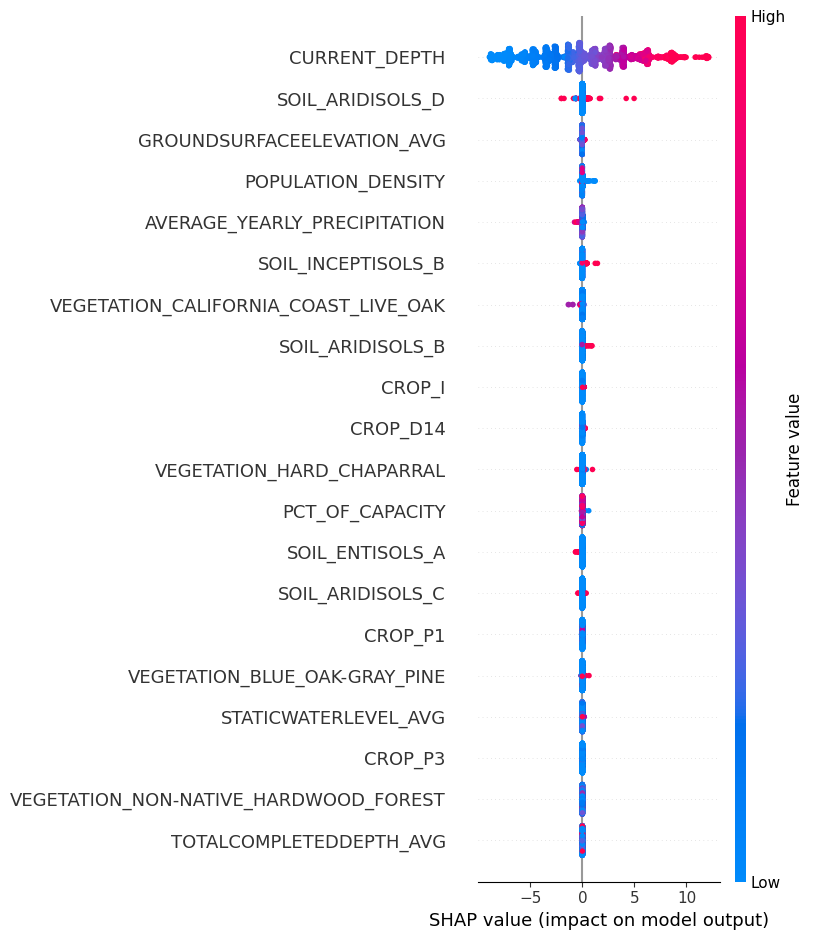

In [10]:

rf_explainer, rf_shap_values = get_explainer_shap(model = models[5].best_estimator_.regressor_, data = X_train_impute_df)
shap.summary_plot(rf_shap_values, X_train_impute_df)

The SHAP model analyzed the dataset and distributed the points (individual circles) per feature. The data points that are colored red increase the predicted value of depth for the feature and the ones colored blue decrease the value of the prediction. The current depth is the major predictor for depth and the  datapoints are distributed with a slightly higher variance on the side where it is decreasing the prediction but appear to be more outliers that are pushing the depth to be deeper as the distribution spreads further right. "Arid" soil 

"Arid Soil" is the second most important predictor as per SHAP and once again the outliers to the right and further increasing the predicted depth. This feature is followed by GroundSurface elevation and population density and precipitation, with lower population interestingly increasing the depth and this perhaps is because decreased population might indicate a rural area dependent more on groundwater than an urban area served by a reservoir. At the same time, "idle" land (Crop_I) and pistachios (Crop-D14) also influence the depth with higher values of these features predicted higher depth. GroundSurface elevation appears in the feature importance of nearly every model analyzed so far with higher elevation predicting greater depth.  

#### An SVR analysis is also performed but the KernelEstimator takes very long to run. (about 12 hours for the entire train datase)

In [12]:
model = models[1].best_estimator_.regressor_
sample = shap.sample(X_train_impute_df, 40)
svr_explainer,svr_shap_values  = get_kernel_explainer_shap (model, sample)


SVR


  0%|          | 0/40 [00:00<?, ?it/s]

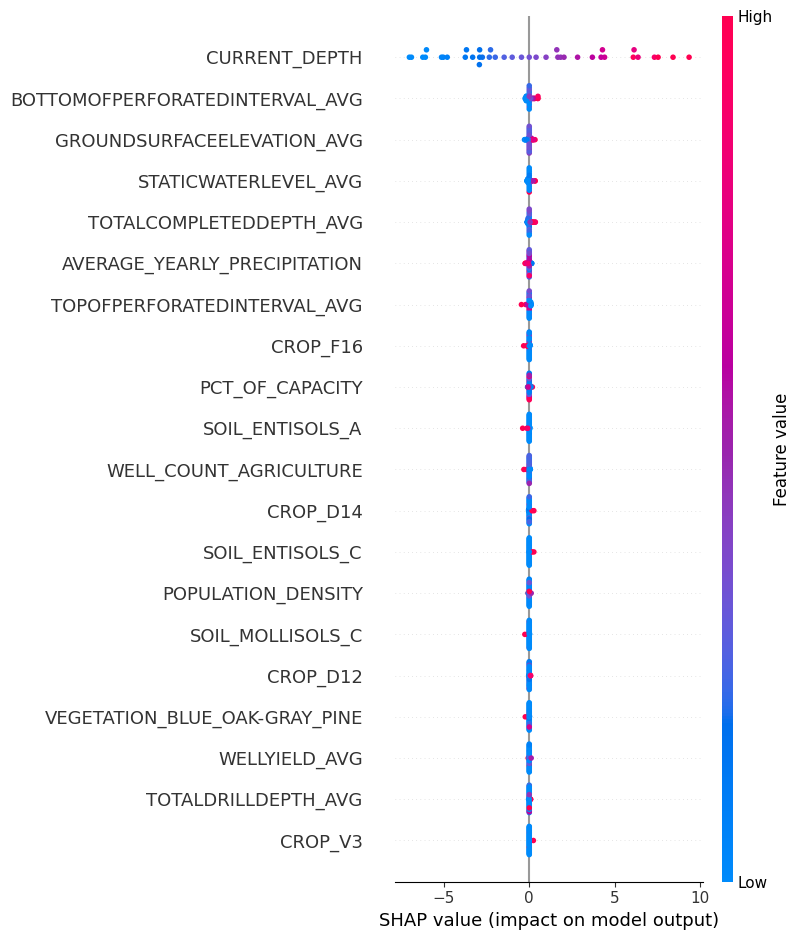

In [13]:
shap.summary_plot(svr_shap_values, sample)


https://www.kaggle.com/code/vikumsw/explaining-random-forest-model-with-shapely-values/notebook

### Difference in feature importance 
-   Support Vector Regressor and Random Forest Regressor 

In [ ]:
create_over_under_pred(models[1], y_pred_test_svr, svr_explainer, X_test_impute_df)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Model : SVR under prediction


Model : SVR over prediction


For the under prediction in SVR, where the baseline is 13.81, the values that lower the prediction are the well perforation depth, the groundsurface elevation and vegetation, another well feature which is the total depth of the well, the pistachios crop and the static water level. In other words, the features of wells in the area cause underprediction of groundwater depth. The current depth, average yearly precipitation followed by arid soil characteristics increase the predicted depth

### Analyze an instance or group of instances in the RandomForestRegressor test set prediction

In [11]:
create_over_under_pred(models[5], y_pred_test_rf, rf_explainer, X_test_impute_df)

Model : RandomForestRegressor under prediction


Model : RandomForestRegressor over prediction


SHAP (SHapley Additive exPlanation) values attribute to each feature the change in the expected model prediction when conditioning on that feature. They explain how to get from the base value E[f(z)] that would be predicted if we did not know any features to the current output f(x). These diagrams above show a single ordering. When the model is non-linear or the input features are not independent, however, the order in which features are added to the expectation matters, and the SHAP values arise from averaging the φi values across all possible orderings.


Predicted value in under prediction (scaled) is 13.50, while base value is 11.9.

 Predicted value in over prediction (scaled) is 20.76, while base value is 11.9 

From the RandomForestRegressor, over and under prediction values, it appears that while current depth is the highest contributor to the determination of the target depth, in the case of an under prediction,  is boosted by the soil aridisols feature by a scaled value of -1.58 and GroundSurfaceElevation. Crops such as alfalfa and idle land feature if negative, contribute to under-prediction.  The over prediction on the other hand is almost completely contributed to (not necessarily caused) by the high current depth value of 8.682 (scaled). 

We have used standard scaling for features and the values are normalized around a mean of 0. It might be interesting to explore the predictions with MinMxScaling with all values scaled to above 0. 

Index(['T10S R21E', 'T15S R10E'], dtype='object', name='TOWNSHIP_RANGE')

,,TOTALDRILLDEPTH_AVG,WELLYIELD_AVG,STATICWATERLEVEL_AVG,TOPOFPERFORATEDINTERVAL_AVG,BOTTOMOFPERFORATEDINTERVAL_AVG,TOTALCOMPLETEDDEPTH_AVG,VEGETATION_NON-NATIVE_HARDWOOD_FOREST,VEGETATION_CALIFORNIA_COAST_LIVE_OAK,VEGETATION_HARD_CHAPARRAL,VEGETATION_BLUE_OAK-GRAY_PINE,...,CROP_D12,CROP_T10,CROP_T8,POPULATION_DENSITY,PCT_OF_CAPACITY,GROUNDSURFACEELEVATION_AVG,CURRENT_DEPTH,AVERAGE_YEARLY_PRECIPITATION,WELL_COUNT_AGRICULTURE,WELL_COUNT_DOMESTIC
TOWNSHIP_RANGE,YEAR,,,,,,,,,,,,,,,,,,,,,
T10S R21E,2020,-0.498229,-0.472862,-0.63148,-0.768477,-0.809372,-0.816633,0.0,0.0,0.003002,0.025695,...,0.0,0.0,0.0,-0.53314,-1.317784,-0.180893,0.786997,1.088229,-0.521918,-0.403081
T15S R10E,2020,-0.498229,-0.472862,-0.63148,-0.768477,-0.809372,-0.816633,0.0,0.0,0.019896,0.038684,...,0.0,0.0,0.0,-0.53558,-1.317784,-0.180893,2.461093,-0.361450,-0.521918,-0.403081


In [ ]:
create_over_under_pred_multiple_samples(type(models[5].best_estimator_.regressor_).__name__, y_pred_test_rf, rf_explainer, X_test_impute_df, 2)

Model : RandomForestRegressor under prediction


Model : RandomForestRegressor over prediction


A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. In this example the log-odds of making over 50k increases significantly between age 20 and 40.

Each dot is a single prediction (row) from the dataset.
The x-axis is the value of the feature (from the X matrix).
The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. For this model the units are log-odds of making over 50k annually.
The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically).

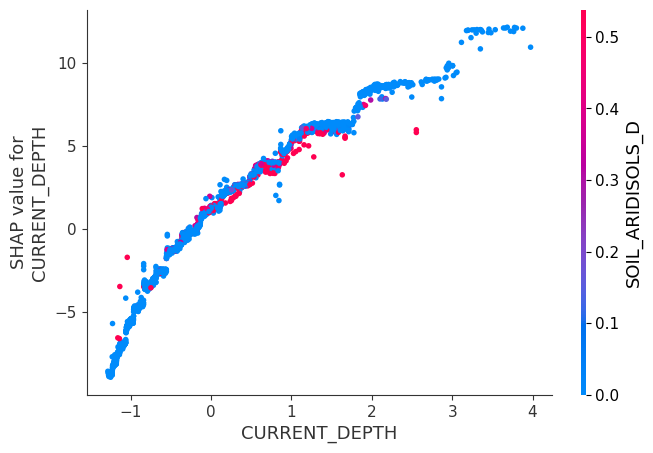

In [14]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot("CURRENT_DEPTH", rf_shap_values, X_train_impute_df)

The above plot shows that the feature importance of Current Depth increases as depth increases. The feature of current depth
also has maximum interaction with arid soils, which hints  why the under prediction values are influenced by the feature value of 
arid soils.  

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>